In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix


In [3]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Create 2 virtual GPUs with 1GB memory each
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024),
         tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPU, 2 Logical GPUs


In [4]:
train='Bot_IoT.csv'

train_data=pd.read_csv(train)

In [5]:
train_data.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [6]:
# number of attack labels 
train_data['label'].value_counts()

1    45332
0    37000
Name: label, dtype: int64

In [7]:
# number of attack labels 
train_data['attack_cat'].value_counts()

Normal            37000
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: attack_cat, dtype: int64

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
id                   82332 non-null int64
dur                  82332 non-null float64
proto                82332 non-null object
service              82332 non-null object
state                82332 non-null object
spkts                82332 non-null int64
dpkts                82332 non-null int64
sbytes               82332 non-null int64
dbytes               82332 non-null int64
rate                 82332 non-null float64
sttl                 82332 non-null int64
dttl                 82332 non-null int64
sload                82332 non-null float64
dload                82332 non-null float64
sloss                82332 non-null int64
dloss                82332 non-null int64
sinpkt               82332 non-null float64
dinpkt               82332 non-null float64
sjit                 82332 non-null float64
djit                 82332 non-null float64
swin                 82332 non-n

In [10]:
del train_data['service']

In [11]:
del train_data['id']
del train_data['state']

In [12]:
# Import label encoder
from sklearn import preprocessing

# label_encoder object knows
# how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
train_data['proto']= label_encoder.fit_transform(train_data['proto'])
train_data['attack_cat']= label_encoder.fit_transform(train_data['attack_cat'])

train_data['proto'].unique()
train_data['attack_cat'].unique()

array([6, 7, 1, 2, 3, 0, 4, 9, 8, 5], dtype=int64)

In [13]:
data = train_data.copy()

In [14]:
del data['attack_cat']

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 41 columns):
dur                  82332 non-null float64
proto                82332 non-null int32
spkts                82332 non-null int64
dpkts                82332 non-null int64
sbytes               82332 non-null int64
dbytes               82332 non-null int64
rate                 82332 non-null float64
sttl                 82332 non-null int64
dttl                 82332 non-null int64
sload                82332 non-null float64
dload                82332 non-null float64
sloss                82332 non-null int64
dloss                82332 non-null int64
sinpkt               82332 non-null float64
dinpkt               82332 non-null float64
sjit                 82332 non-null float64
djit                 82332 non-null float64
swin                 82332 non-null int64
stcpb                82332 non-null int64
dtcpb                82332 non-null int64
dwin                 82332 non-null

In [16]:
X = data.drop(["label"],axis =1)
y = data["label"]

In [17]:
from sklearn.feature_selection import SelectKBest, SelectPercentile, mutual_info_classif

selector = SelectPercentile(mutual_info_classif, percentile=30)
X_reduced = selector.fit_transform(X, y)
X_reduced.shape

(82332, 12)

In [18]:
cols = selector.get_support(indices=True)
selected_columns = X.iloc[:,cols].columns.tolist()
selected_columns

['dur',
 'sbytes',
 'dbytes',
 'rate',
 'sttl',
 'dttl',
 'sload',
 'dload',
 'dinpkt',
 'smean',
 'dmean',
 'ct_state_ttl']

In [19]:
df = data[['dur',
 'sbytes',
 'dbytes',
 'rate',
 'sttl',
 'dttl',
 'sload',
 'dload',
 'dinpkt',
 'smean',
 'dmean',
 'ct_state_ttl',
             'label']]
df.to_csv('bot_process.csv')

In [9]:
df = pd.read_csv('bot_process.csv')

In [10]:
del df['Unnamed: 0']

In [11]:
df['label'].value_counts()

1    45332
0    37000
Name: label, dtype: int64

In [12]:
X = df.drop(["label"],axis =1)
y = df["label"]

In [13]:
# splitting the dataset 80% for training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)
print (X_train.shape, y_train.shape)
print( X_test.shape, y_test.shape)

(65865, 12) (65865,)
(16467, 12) (16467,)


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [15]:
# Plot of accuracy vs epoch for train and test dataset
import matplotlib.pyplot as plt

In [36]:
ML_Model = []
accuracy = []
precision = []
recall = []
f1score = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
    ML_Model.append(model)
    accuracy.append(round(a, 3))
    precision.append(round(b, 3))
    recall.append(round(c, 3))
    f1score.append(round(d, 3))

# CNN

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

In [28]:
X_train=X_train.values
X_test=X_test.values

X_train = X_train.reshape(-1, X_train.shape[1],1)
X_test = X_test.reshape(-1, X_test.shape[1],1)

Y_train=to_categorical(y_train)
Y_test=to_categorical(y_test)

In [29]:
verbose, epoch, batch_size = 1, 100, 4
activationFunction='relu'

def CNN():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = CNN()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 11, 128)           384       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 128)            0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 128)            0         
_________________________________________________________________
flatten (Flatten)            (None, 640)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1282      
Total params: 1,666
Trainable params: 1,666
Non-trainable params: 0
_________________________________________________________________


In [30]:
modelhistory = cnnmodel.fit(X_train, Y_train, epochs=5, verbose=verbose, validation_split=0.2, batch_size = 2)

Epoch 1/5
13173/13173 [==============================] - 39s 3ms/step - loss: 158461.5469 - accuracy: 0.6777 - val_loss: 0.4993 - val_accuracy: 0.7427
Epoch 2/5
13173/13173 [==============================] - 35s 3ms/step - loss: 1.2248 - accuracy: 0.7393 - val_loss: 0.4907 - val_accuracy: 0.7588
Epoch 3/5
13173/13173 [==============================] - 35s 3ms/step - loss: 0.5158 - accuracy: 0.7583 - val_loss: 0.4834 - val_accuracy: 0.7748
Epoch 4/5
13173/13173 [==============================] - 34s 3ms/step - loss: 1.3306 - accuracy: 0.7629 - val_loss: 0.4787 - val_accuracy: 0.7754
Epoch 5/5
13173/13173 [==============================] - 35s 3ms/step - loss: 0.5068 - accuracy: 0.7667 - val_loss: 0.4785 - val_accuracy: 0.7754


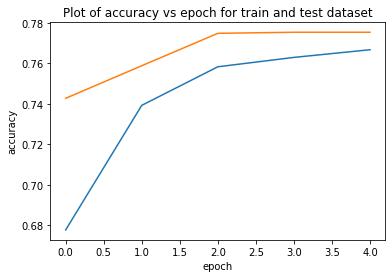

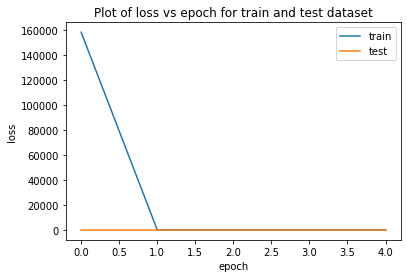

In [32]:

plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title("Plot of accuracy vs epoch for train and test dataset")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# Plot of loss vs epoch for train and test dataset
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [33]:
y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

#y_prob = cnnmodel.predict_proba(X_test)[:, 1]

cnn_acc = accuracy_score(y_pred, y_test)
cnn_prec = precision_score(y_pred, y_test,average='weighted')
cnn_rec = recall_score(y_pred, y_test,average='weighted')
cnn_f1 = f1_score(y_pred, y_test,average='weighted')

#storeResults('CNN',dl_acc,dl_prec,dl_rec,dl_f1)

515/515 [==============================] - 0s 549us/step


In [37]:
storeResults('CNN',cnn_acc,cnn_prec,cnn_rec,cnn_f1)

# LSTM

In [29]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout
from keras import regularizers
import tensorflow as tf

# define a function to build the keras model
def create_model(input_shape):
    # create model
    d = 0.25
    model = Sequential()
    
    model.add(LSTM(32, input_shape=input_shape, activation='relu', return_sequences=True))
    model.add(Dropout(d))

    model.add(LSTM(64, input_shape=input_shape, activation='relu', return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(128, input_shape=input_shape, activation='relu', return_sequences=True))
    model.add(Dropout(d))

    model.add(LSTM(256, input_shape=input_shape, activation='relu', return_sequences=False))
    model.add(Dropout(d))
   
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # compile model
    adam = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.00001)
    #model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model(input_shape=(12,1))
#print(model.summary())

In [30]:
history=model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=5, batch_size=5, verbose=1, steps_per_epoch=500, validation_steps=500)

Epoch 1/5
500/500 [==============================] - 100s 164ms/step - loss: 6.2089e-08 - accuracy: 0.5189 - val_loss: 6.5708e-08 - val_accuracy: 0.5692
Epoch 2/5
500/500 [==============================] - 81s 161ms/step - loss: 6.2855e-08 - accuracy: 0.5548 - val_loss: 6.5708e-08 - val_accuracy: 0.5692
Epoch 3/5
500/500 [==============================] - 80s 161ms/step - loss: 6.7795e-08 - accuracy: 0.5800 - val_loss: 6.5708e-08 - val_accuracy: 0.5692
Epoch 4/5
500/500 [==============================] - 73s 147ms/step - loss: 6.5234e-08 - accuracy: 0.5580 - val_loss: 6.5708e-08 - val_accuracy: 0.5692
Epoch 5/5
500/500 [==============================] - 67s 133ms/step - loss: 6.5569e-08 - accuracy: 0.5720 - val_loss: 6.5708e-08 - val_accuracy: 0.5692


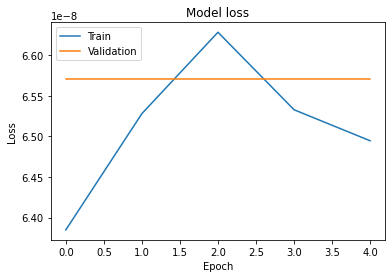

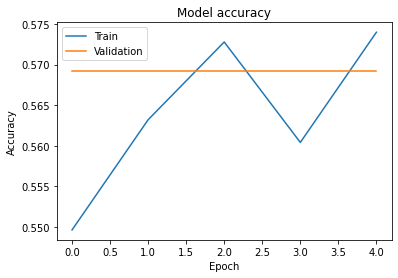

515/515 [==============================] - 21s 39ms/step


In [35]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

y_pred = model.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)


#y_prob = cnnmodel.predict_proba(X_test)[:, 1]

lstm_acc = accuracy_score(y_pred, y_test)
lstm_prec = precision_score(y_pred, y_test,average='weighted')
lstm_rec = recall_score(y_pred, y_test,average='weighted')
lstm_f1 = f1_score(y_pred, y_test,average='weighted')

#

In [39]:
storeResults('LSTM',lstm_acc,lstm_prec,lstm_rec,lstm_f1)

# CNN + LSTM

In [44]:
import tensorflow as tf
tf.keras.backend.clear_session()

model_en = tf.keras.models.Sequential([tf.keras.layers.Conv1D(filters=64,kernel_size=5,strides=1,padding="causal",activation="relu",input_shape=(X_train.shape[1],X_train.shape[2])),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="valid"),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="valid"),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(2)
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(5e-4,
                                                             decay_steps=1000000,
                                                             decay_rate=0.98,
                                                             staircase=False)

model_en.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.8),
              metrics=['acc'])
model_en.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 12, 64)            384       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 32)            6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 10, 128)           82432     
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [48]:
modelhistory = model_en.fit(X_train, Y_train, epochs=5, verbose=verbose, validation_split=0.2, batch_size = 8)

Epoch 1/5
6587/6587 [==============================] - 62s 9ms/step - loss: 0.2476 - acc: 0.5497 - val_loss: 0.2472 - val_acc: 0.5554
Epoch 2/5
6587/6587 [==============================] - 61s 9ms/step - loss: 0.2476 - acc: 0.5497 - val_loss: 0.2469 - val_acc: 0.5554
Epoch 3/5
6587/6587 [==============================] - 61s 9ms/step - loss: 0.2476 - acc: 0.5497 - val_loss: 0.2469 - val_acc: 0.5554
Epoch 4/5
6587/6587 [==============================] - 61s 9ms/step - loss: 0.2476 - acc: 0.5497 - val_loss: 0.2470 - val_acc: 0.5554
Epoch 5/5
6587/6587 [==============================] - 61s 9ms/step - loss: 0.2476 - acc: 0.5497 - val_loss: 0.2470 - val_acc: 0.5554


In [52]:
y_pred = model_en.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

#y_prob = cnnmodel.predict_proba(X_test)[:, 1]

ense_acc = accuracy_score(y_pred, y_test)
ense_prec = precision_score(y_pred, y_test,average='weighted')
ense_rec = recall_score(y_pred, y_test,average='weighted')
ense_f1 = f1_score(y_pred, y_test,average='weighted')

515/515 [==============================] - 1s 2ms/step


In [40]:
storeResults('CNN + LSTM',ense_acc,ense_prec,ense_rec,ense_f1)

# DNN

In [16]:
# splitting the dataset 80% for training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

In [17]:
import matplotlib.pyplot as plt
n_train = np.array(X_train)
n_test = np.array(X_test)

12
(65865, 12)


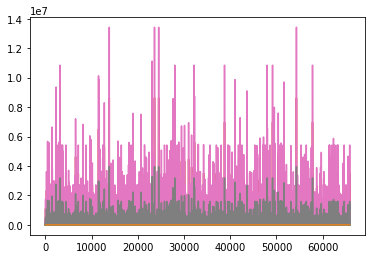

In [18]:
from keras.layers import Input, Dense
from keras.models import Model
import tensorflow as tf

input_dim = n_train.shape[1]
feature_dim = [25, 20, 15, 10]
print(input_dim)
inputs = Input(shape=(input_dim,))
encoded = inputs
encoded = Dense(feature_dim[0], kernel_initializer="uniform")(encoded)
encoded = Dense(feature_dim[1], kernel_initializer="uniform")(encoded)
encoded = Dense(feature_dim[2], kernel_initializer="uniform")(encoded)
encoded = Dense(feature_dim[3], kernel_initializer="uniform")(encoded)

decoded = encoded
decoded = Dense(feature_dim[2], kernel_initializer="uniform")(decoded)
decoded = Dense(feature_dim[1], kernel_initializer="uniform")(decoded)
decoded = Dense(feature_dim[0], kernel_initializer="uniform")(decoded)
decoded = Dense(input_dim, kernel_initializer="uniform")(decoded)


autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adadelta', loss='mse')

autoencoder.fit(n_train, n_train,
                verbose=0,
                epochs=10,
                batch_size=2,
                shuffle=True,
                validation_data=(n_test, n_test))

predict_vals = autoencoder.predict(n_train)
print(predict_vals.shape)
plt.plot(predict_vals)
plt.show()

In [19]:
from keras.models import Sequential

featuremodel = Sequential()
featuremodel.add(Dense(feature_dim[0], input_shape=(input_dim,), weights=autoencoder.layers[1].get_weights()))
featuremodel.add(Dense(feature_dim[1], weights=autoencoder.layers[2].get_weights()))
featuremodel.add(Dense(feature_dim[2], weights=autoencoder.layers[3].get_weights()))
featuremodel.add(Dense(feature_dim[3], weights=autoencoder.layers[4].get_weights()))

featuremodel.compile(optimizer='adadelta', loss='mse')

from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
model4 = BaggingClassifier(MLPClassifier(),n_estimators=10, random_state=0)
model4.fit(X_train,y_train)

BaggingClassifier(base_estimator=MLPClassifier(), random_state=0)

In [22]:
# classic svm with deep autoencoder
deepmodel = model4
deepmodel.fit(featuremodel.predict(n_train),y_train)
deepprediction=deepmodel.predict(featuremodel.predict(n_test))
#print("Accuracy : %s" % "{0:.3%}".format(metrics.accuracy_score(deepprediction, y_test)))

In [23]:
dnn_acc = accuracy_score(deepprediction, y_test)
dnn_prec = precision_score(deepprediction, y_test,average='weighted')
dnn_rec = recall_score(deepprediction, y_test,average='weighted')
dnn_f1 = f1_score(deepprediction, y_test,average='weighted')

In [42]:
storeResults('DNN',dnn_acc,dnn_prec,dnn_rec,dnn_f1)

# Comparison

In [43]:
#creating dataframe
import pandas as pd
import numpy as np
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : accuracy,
                        'f1_score' : f1score,
                        'Recall'   : recall,
                        'Precision': precision,
                        
                      })

In [44]:
result

,ML Model,Accuracy,f1_score,Recall,Precision
0,CNN,0.77,0.814,0.77,0.770
1,LSTM,0.45,0.621,0.45,1.000
2,CNN + LSTM,0.55,1.000,0.55,0.709
3,DNN,0.45,1.000,0.45,0.621


In [ ]:
cnnmodel.save('model_bot.h5')

# Graph

In [45]:
classifier = ML_Model
y_pos = np.arange(len(classifier))

# Accuracy

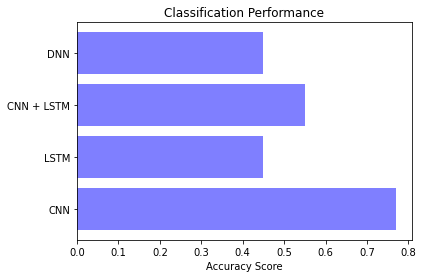

In [46]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, accuracy, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Accuracy Score')
plt2.title('Classification Performance')
plt2.show()

# Precision

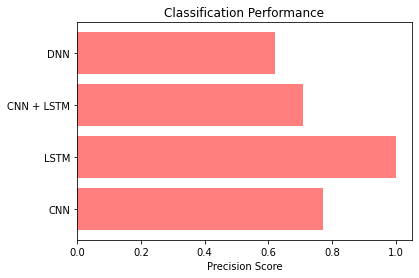

In [47]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, precision, align='center', alpha=0.5,color='red')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Precision Score')
plt2.title('Classification Performance')
plt2.show()

# Recall

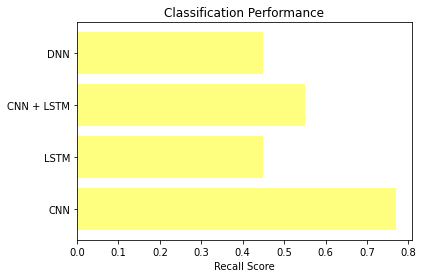

In [48]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, recall, align='center', alpha=0.5,color='yellow')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Recall Score')
plt2.title('Classification Performance')
plt2.show()

# F1 Score

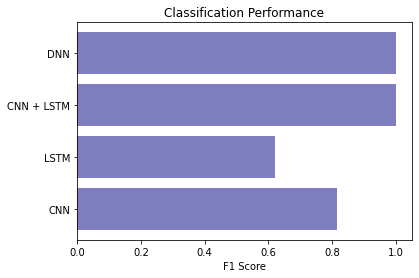

In [49]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, f1score, align='center', alpha=0.5,color='navy')
plt2.yticks(y_pos, classifier)
plt2.xlabel('F1 Score')
plt2.title('Classification Performance')
plt2.show()